In [11]:
import geopandas as gpd
import rasterio
from rasterio.plot import show 
from rasterstats import zonal_stats

shapefile_path = '../../data/gsi_go_jp/gm-jpn-all_u_2_2/polbnda_jpn.shp'

admin =  gpd.read_file(shapefile_path)
admin

,f_code,coc,nam,laa,pop,ypc,adm_code,salb,soc,geometry
0,FA001,JPN,Hokkai Do,Sapporo Shi,1930496,2014,01100,UNK,JPN,"POLYGON ((141.44980 43.16333, 141.44769 43.157..."
1,FA001,JPN,Hokkai Do,Hakodate Shi,274485,2014,01202,UNK,JPN,"POLYGON ((140.86501 42.01013, 140.86800 42.008..."
2,FA001,JPN,Hokkai Do,Otaru Shi,127224,2014,01203,UNK,JPN,"POLYGON ((141.24820 43.15973, 141.24680 43.158..."
3,FA001,JPN,Hokkai Do,Asahikawa Shi,349057,2014,01204,UNK,JPN,"POLYGON ((142.43280 43.94814, 142.43790 43.944..."
4,FA001,JPN,Hokkai Do,Muroran Shi,91276,2014,01205,UNK,JPN,"POLYGON ((140.99080 42.43800, 140.99680 42.436..."
...,...,...,...,...,...,...,...,...,...,...
2909,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((139.80595 35.58558, 139.79480 35.592..."
2910,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((140.05172 31.43784, 140.05053 31.437..."
2911,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((140.29860 30.47233, 140.28740 30.482..."
2912,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((140.34214 29.79279, 140.34153 29.792..."


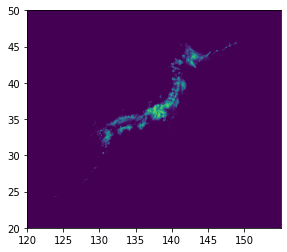

In [12]:
raster_path = '../../data/gsi_go_jp/gm-jpn-el_u_1_1/jpn/el.tif'

with rasterio.open(raster_path) as raster:
    show(raster)

In [13]:
stats = zonal_stats(shapefile_path, raster_path)
stats

/home/takahisa/anaconda/envs/py37/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'min': 2.0, 'max': 108.0, 'mean': 42.73864273696018, 'count': 1783},
 {'min': 2.0, 'max': 103.0, 'mean': 25.25967894239849, 'count': 1059},
 {'min': 2.0, 'max': 106.0, 'mean': 30.239185750636132, 'count': 393},
 {'min': 9.0, 'max': 105.0, 'mean': 29.12873754152824, 'count': 1204},
 {'min': 2.0, 'max': 70.0, 'mean': 13.178294573643411, 'count': 129},
 {'min': 2.0, 'max': 107.0, 'mean': 31.000651465798047, 'count': 1535},
 {'min': 2.0, 'max': 63.0, 'mean': 19.815625, 'count': 640},
 {'min': 4.0, 'max': 118.0, 'mean': 38.14096016343208, 'count': 979},
 {'min': 2.0, 'max': 114.0, 'mean': 32.27965367965368, 'count': 2310},
 {'min': 10.0, 'max': 110.0, 'mean': 51.12613355317395, 'count': 1213},
 {'min': 2.0, 'max': 74.0, 'mean': 11.903896103896104, 'count': 770},
 {'min': 2.0, 'max': 30.0, 'mean': 6.722368421052631, 'count': 760},
 {'min': 2.0, 'max': 67.0, 'mean': 13.245833333333334, 'count': 480},
 {'min': 2.0, 'max': 92.0, 'mean': 10.48931383577053, 'count': 889},
 {'min': 2.0, 'max': 2